In [1]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 408 (delta 267), reused 228 (delta 164), pack-reused 74 (from 1)
Receiving objects: 100% (408/408), 1.83 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [24]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 6), reused 7 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 4.56 KiB | 62.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 87548fc..a14f059
Fast-forward
 fed_lib/utils.py |   4 +-
 fedgh.ipynb      |  10 -
 fedsam.ipynb     | 673 ++++++-------------------------------------
 task2.ipynb      | 857 +++++++++++++++++++++++++++++++++++++++++++++----------
 4 files changed, 783 insertions(+), 761 deletions(-)


In [25]:
%cd test

[Errno 2] No such file or directory: 'test'
/kaggle/working/test


In [26]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedAvg & Local Optimization

In [27]:
import torch
import torch.nn as nn

In [ ]:
!pip install fedlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:0

In [28]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [29]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
trainset, testset = utils.get_cifar10()

In [32]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def fed_avg_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedAvg(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)


    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k} Steps')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [33]:
#experimental setup 1.
from IPython.display import clear_output

metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for k in [1, 5, 10, 20]: 
    f = fed_avg_exp(lr=1.5e-2, num_clients=5,num_steps=k, global_runs=50, sampling_frac=1.0)
    metrics_exp_1[k] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 steps
Training Client 5/5 for 1 steps


KeyboardInterrupt: 

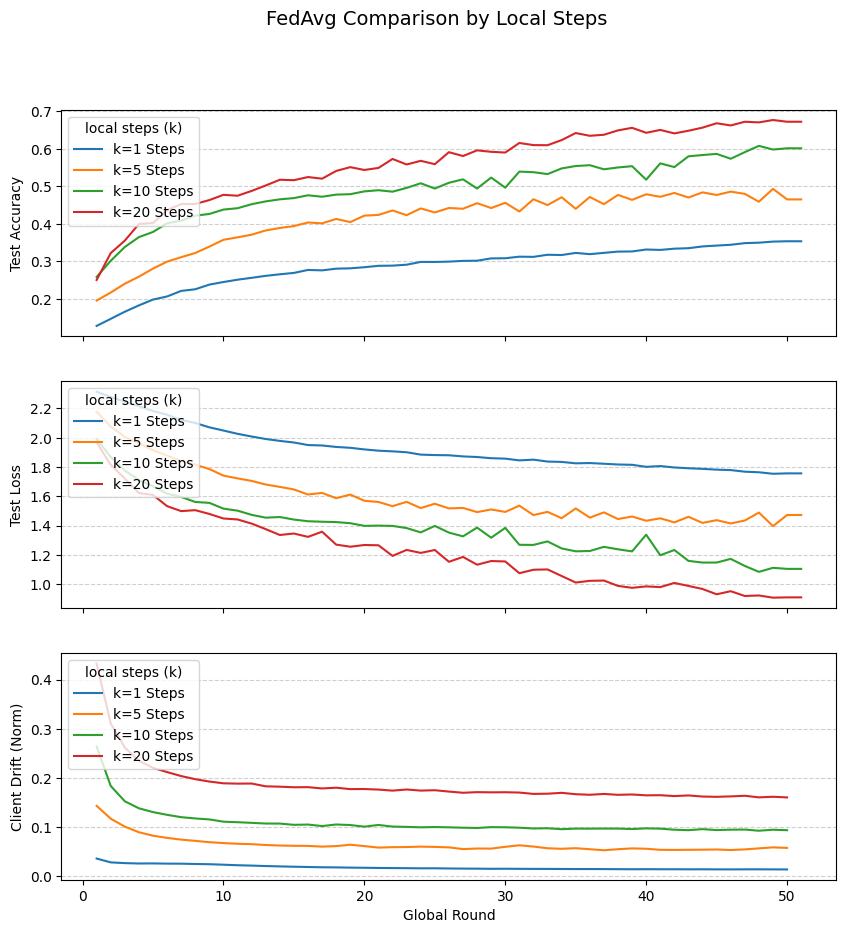

In [ ]:
plot_metrics(metrics_exp_1, title="FedAvg Comparison by Local Steps", label="k", label_desc="local steps")

In [35]:
#experimental setup 2.
from IPython.display import clear_output
metrics_exp_2 = {}
total_samples = len(trainset.dataset)

for frac in [0.2, 0.5, 1.0]: 
    f = fed_avg_exp(lr=1.5e-2, num_clients=5, num_steps=5, global_runs=50, sampling_frac=frac)
    metrics_exp_2[frac] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.072692e-03
Client Drift Std: 4.439987e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.022031e-03
Client Number: 3 Drift :2.022738e-03
Client Number: 1 Drift :2.076382e-03
Client Number: 0 Drift :2.114674e-03
Client Number: 4 Drift :2.127635e-03

Evaluate on round 1:


FedAvg  | Test Loss: 2.3039, Test Acc: 10.00%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.060759e-03
Client Drift Std: 5.182141e-05
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.992450e-03
Client Number: 2 Drift :2.008642e-03
Client Number: 1 Drift :2.077697e-03
Client Number: 0 Drift :2.098309e-03
Client Number: 4 Drift :2.126699e-03

Evaluate on round 2:


FedAvg  | Test Loss: 2.3039, Test Acc: 10.00%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.035384e-03
Client Drift Std: 5.925904e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.963757e-03
Client Number: 3 Drift :1.968390e-03
Client Number: 1 Drift :2.053899e-03
Client Number: 0 Drift :2.081581e-03
Client Number: 4 Drift :2.109293e-03

Evaluate on round 3:


FedAvg  | Test Loss: 2.3038, Test Acc: 10.00%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.011184e-03
Client Drift Std: 5.272215e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.943274e-03
Client Number: 3 Drift :1.955218e-03
Client Number: 1 Drift :2.026404e-03
Client Number: 0 Drift :2.062370e-03
Client Number: 4 Drift :2.068651e-03

Evaluate on round 4:


FedAvg  | Test Loss: 2.3038, Test Acc: 10.00%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.995248e-03
Client Drift Std: 5.469658e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.926391e-03
Client Number: 3 Drift :1.938243e-03
Client Number: 1 Drift :2.005288e-03
Client Number: 4 Drift :2.044234e-03
Client Number: 0 Drift :2.062086e-03

Evaluate on round 5:


FedAvg  | Test Loss: 2.3038, Test Acc: 10.00%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.970904e-03
Client Drift Std: 5.455409e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.895395e-03
Client Number: 3 Drift :1.914557e-03
Client Number: 0 Drift :2.008362e-03
Client Number: 1 Drift :2.009574e-03
Client Number: 4 Drift :2.026633e-03

Evaluate on round 6:


FedAvg  | Test Loss: 2.3037, Test Acc: 10.00%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.949921e-03
Client Drift Std: 5.347229e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.873429e-03
Client Number: 3 Drift :1.907231e-03
Client Number: 1 Drift :1.959733e-03
Client Number: 0 Drift :1.988090e-03
Client Number: 4 Drift :2.021123e-03

Evaluate on round 7:


FedAvg  | Test Loss: 2.3037, Test Acc: 10.00%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.930496e-03
Client Drift Std: 5.471707e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.861868e-03
Client Number: 3 Drift :1.873610e-03
Client Number: 1 Drift :1.944879e-03
Client Number: 0 Drift :1.968141e-03
Client Number: 4 Drift :2.003981e-03

Evaluate on round 8:


FedAvg  | Test Loss: 2.3036, Test Acc: 10.00%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.906647e-03
Client Drift Std: 4.746724e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.836916e-03
Client Number: 3 Drift :1.864970e-03
Client Number: 1 Drift :1.931606e-03
Client Number: 0 Drift :1.937490e-03
Client Number: 4 Drift :1.962254e-03

Evaluate on round 9:


FedAvg  | Test Loss: 2.3036, Test Acc: 10.00%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.889607e-03
Client Drift Std: 4.513524e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.818210e-03
Client Number: 3 Drift :1.858873e-03
Client Number: 1 Drift :1.903666e-03
Client Number: 0 Drift :1.927823e-03
Client Number: 4 Drift :1.939463e-03

Evaluate on round 10:


FedAvg  | Test Loss: 2.3036, Test Acc: 10.00%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.874800e-03
Client Drift Std: 4.887400e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.813738e-03
Client Number: 3 Drift :1.817468e-03
Client Number: 1 Drift :1.901309e-03
Client Number: 0 Drift :1.919456e-03
Client Number: 4 Drift :1.922033e-03

Evaluate on round 11:


FedAvg  | Test Loss: 2.3035, Test Acc: 10.00%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.862471e-03
Client Drift Std: 4.981000e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.792224e-03
Client Number: 3 Drift :1.826504e-03
Client Number: 1 Drift :1.869859e-03
Client Number: 0 Drift :1.886995e-03
Client Number: 4 Drift :1.936774e-03

Evaluate on round 12:


FedAvg  | Test Loss: 2.3035, Test Acc: 10.00%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.847358e-03
Client Drift Std: 5.391124e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.768245e-03
Client Number: 3 Drift :1.798954e-03
Client Number: 1 Drift :1.871584e-03
Client Number: 4 Drift :1.896896e-03
Client Number: 0 Drift :1.901111e-03

Evaluate on round 13:


FedAvg  | Test Loss: 2.3034, Test Acc: 10.00%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.819194e-03
Client Drift Std: 4.753518e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.762131e-03
Client Number: 3 Drift :1.765251e-03
Client Number: 1 Drift :1.832412e-03
Client Number: 0 Drift :1.858701e-03
Client Number: 4 Drift :1.877473e-03

Evaluate on round 14:


FedAvg  | Test Loss: 2.3034, Test Acc: 10.00%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.807706e-03
Client Drift Std: 5.377754e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.734780e-03
Client Number: 3 Drift :1.751034e-03
Client Number: 1 Drift :1.838144e-03
Client Number: 0 Drift :1.850678e-03
Client Number: 4 Drift :1.863896e-03

Evaluate on round 15:


FedAvg  | Test Loss: 2.3034, Test Acc: 10.00%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.796722e-03
Client Drift Std: 4.785413e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.733432e-03
Client Number: 3 Drift :1.744026e-03
Client Number: 1 Drift :1.824890e-03
Client Number: 0 Drift :1.837596e-03
Client Number: 4 Drift :1.843664e-03

Evaluate on round 16:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.774375e-03
Client Drift Std: 4.638130e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.708474e-03
Client Number: 3 Drift :1.733566e-03
Client Number: 1 Drift :1.787511e-03
Client Number: 0 Drift :1.811233e-03
Client Number: 4 Drift :1.831091e-03

Evaluate on round 17:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.758817e-03
Client Drift Std: 5.115564e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.690695e-03
Client Number: 3 Drift :1.705017e-03
Client Number: 1 Drift :1.779614e-03
Client Number: 0 Drift :1.807983e-03
Client Number: 4 Drift :1.810775e-03

Evaluate on round 18:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.754195e-03
Client Drift Std: 4.298639e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.690399e-03
Client Number: 3 Drift :1.717640e-03
Client Number: 1 Drift :1.769854e-03
Client Number: 4 Drift :1.795659e-03
Client Number: 0 Drift :1.797420e-03

Evaluate on round 19:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.736617e-03
Client Drift Std: 5.255312e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.669427e-03
Client Number: 3 Drift :1.676451e-03
Client Number: 1 Drift :1.767883e-03
Client Number: 4 Drift :1.778330e-03
Client Number: 0 Drift :1.790996e-03

Evaluate on round 20:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.724790e-03
Client Drift Std: 5.121802e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.661191e-03
Client Number: 3 Drift :1.665257e-03
Client Number: 1 Drift :1.753787e-03
Client Number: 0 Drift :1.760550e-03
Client Number: 4 Drift :1.783166e-03

Evaluate on round 21:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.713519e-03
Client Drift Std: 4.212857e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.654266e-03
Client Number: 3 Drift :1.673291e-03
Client Number: 0 Drift :1.735720e-03
Client Number: 1 Drift :1.740633e-03
Client Number: 4 Drift :1.763687e-03

Evaluate on round 22:


FedAvg  | Test Loss: 2.3031, Test Acc: 10.00%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.702132e-03
Client Drift Std: 4.490155e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.639481e-03
Client Number: 3 Drift :1.655788e-03
Client Number: 1 Drift :1.733176e-03
Client Number: 4 Drift :1.739371e-03
Client Number: 0 Drift :1.742843e-03

Evaluate on round 23:


FedAvg  | Test Loss: 2.3031, Test Acc: 10.00%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.691027e-03
Client Drift Std: 5.068653e-05
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.622790e-03
Client Number: 3 Drift :1.641537e-03
Client Number: 1 Drift :1.702972e-03
Client Number: 4 Drift :1.742825e-03
Client Number: 0 Drift :1.745011e-03

Evaluate on round 24:


FedAvg  | Test Loss: 2.3031, Test Acc: 10.00%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps


Exception in thread Thread-602 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step


KeyboardInterrupt: 

    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_sharer.py", line 86, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 525, in Client
    answer_challenge(c, authkey)
  File "/usr/lib/python3.11/multiprocessing/con

In [ ]:
plot_metrics(metrics_exp_2, title="FedAvg Comparison by Percentage Clients Sample", label="f", label_desc="frac")

: 

In [ ]:
#experimental setup 3.
metrics_exp_3 = {}
for alpha in [1e4, 0.01, 0.1, 1,10]: 
    f = fed_avg_exp(lr=2.5e-2, num_clients=5,num_steps=75, global_runs=25, alpha=alpha, sampling_frac=1)
    metrics_exp_3[k] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.306409e+00
Client Drift Std: 6.408696e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.269138e+00
Client Number: 3 Drift :1.272064e+00
Client Number: 0 Drift :1.277350e+00
Client Number: 1 Drift :1.279111e+00
Client Number: 2 Drift :1.434383e+00

Evaluate on round 1:


FedAvg  | Test Loss: 1.7579, Test Acc: 36.24%

--- Round 2/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 8.973013e-01
Client Drift Std: 7.519688e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :8.463749e-01
Client Number: 4 Drift :8.512940e-01
Client Number: 0 Drift :8.606452e-01
Client Number: 1 Drift :8.825614e-01
Client Number: 2 Drift :1.045631e+00

Evaluate on round 2:


FedAvg  | Test Loss: 1.4775, Test Acc: 46.51%

--- Round 3/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.874892e-01
Client Drift Std: 7.133910e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :7.398536e-01
Client Number: 0 Drift :7.471754e-01
Client Number: 3 Drift :7.526219e-01
Client Number: 1 Drift :7.689154e-01
Client Number: 2 Drift :9.288797e-01

Evaluate on round 3:


FedAvg  | Test Loss: 1.3523, Test Acc: 51.44%

--- Round 4/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.393912e-01
Client Drift Std: 6.126867e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :6.994402e-01
Client Number: 4 Drift :7.013681e-01
Client Number: 0 Drift :7.125725e-01
Client Number: 1 Drift :7.228044e-01
Client Number: 2 Drift :8.607709e-01

Evaluate on round 4:


FedAvg  | Test Loss: 1.3146, Test Acc: 52.76%

--- Round 5/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.200175e-01
Client Drift Std: 6.998550e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.692566e-01
Client Number: 3 Drift :6.721098e-01
Client Number: 0 Drift :6.834868e-01
Client Number: 1 Drift :7.200000e-01
Client Number: 2 Drift :8.552341e-01

Evaluate on round 5:


FedAvg  | Test Loss: 1.2745, Test Acc: 54.12%

--- Round 6/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.064937e-01
Client Drift Std: 6.515525e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.595855e-01
Client Number: 3 Drift :6.690950e-01
Client Number: 0 Drift :6.705896e-01
Client Number: 1 Drift :6.990988e-01
Client Number: 2 Drift :8.340994e-01

Evaluate on round 6:


FedAvg  | Test Loss: 1.1920, Test Acc: 57.69%

--- Round 7/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.948176e-01
Client Drift Std: 7.174754e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.499118e-01
Client Number: 3 Drift :6.607040e-01
Client Number: 4 Drift :6.618429e-01
Client Number: 1 Drift :6.636379e-01
Client Number: 2 Drift :8.379915e-01

Evaluate on round 7:


FedAvg  | Test Loss: 1.1781, Test Acc: 58.69%

--- Round 8/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.893577e-01
Client Drift Std: 7.206349e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :6.443648e-01
Client Number: 4 Drift :6.444462e-01
Client Number: 0 Drift :6.536722e-01
Client Number: 1 Drift :6.722637e-01
Client Number: 2 Drift :8.320415e-01

Evaluate on round 8:


FedAvg  | Test Loss: 1.1074, Test Acc: 60.51%

--- Round 9/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.824893e-01
Client Drift Std: 7.103703e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.314165e-01
Client Number: 0 Drift :6.405746e-01
Client Number: 3 Drift :6.480323e-01
Client Number: 1 Drift :6.701928e-01
Client Number: 2 Drift :8.222303e-01

Evaluate on round 9:


FedAvg  | Test Loss: 1.0720, Test Acc: 62.28%

--- Round 10/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.737546e-01
Client Drift Std: 6.780784e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.303048e-01
Client Number: 4 Drift :6.346226e-01
Client Number: 3 Drift :6.373981e-01
Client Number: 1 Drift :6.584731e-01
Client Number: 2 Drift :8.079746e-01

Evaluate on round 10:


FedAvg  | Test Loss: 1.0781, Test Acc: 61.92%

--- Round 11/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.684375e-01
Client Drift Std: 6.888830e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.216545e-01
Client Number: 4 Drift :6.265908e-01
Client Number: 3 Drift :6.360389e-01
Client Number: 1 Drift :6.534050e-01
Client Number: 2 Drift :8.044983e-01

Evaluate on round 11:


FedAvg  | Test Loss: 0.9462, Test Acc: 66.47%

--- Round 12/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.630525e-01
Client Drift Std: 7.006323e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.191889e-01
Client Number: 0 Drift :6.195548e-01
Client Number: 3 Drift :6.338807e-01
Client Number: 1 Drift :6.404265e-01
Client Number: 2 Drift :8.022117e-01

Evaluate on round 12:


FedAvg  | Test Loss: 0.9275, Test Acc: 67.35%

--- Round 13/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.698725e-01
Client Drift Std: 8.162210e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.173422e-01
Client Number: 4 Drift :6.241977e-01
Client Number: 3 Drift :6.308392e-01
Client Number: 1 Drift :6.448849e-01
Client Number: 2 Drift :8.320984e-01

Evaluate on round 13:


FedAvg  | Test Loss: 0.9628, Test Acc: 66.17%

--- Round 14/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.565447e-01
Client Drift Std: 7.461039e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.069899e-01
Client Number: 4 Drift :6.212689e-01
Client Number: 3 Drift :6.218308e-01
Client Number: 1 Drift :6.274829e-01
Client Number: 2 Drift :8.051510e-01

Evaluate on round 14:


FedAvg  | Test Loss: 0.9307, Test Acc: 67.37%

--- Round 15/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.525979e-01
Client Drift Std: 7.232637e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.081166e-01
Client Number: 4 Drift :6.106523e-01
Client Number: 1 Drift :6.202821e-01
Client Number: 3 Drift :6.273426e-01
Client Number: 2 Drift :7.965957e-01

Evaluate on round 15:


FedAvg  | Test Loss: 0.8859, Test Acc: 69.31%

--- Round 16/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.456146e-01
Client Drift Std: 6.588799e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.025038e-01
Client Number: 4 Drift :6.036261e-01
Client Number: 1 Drift :6.215879e-01
Client Number: 3 Drift :6.241744e-01
Client Number: 2 Drift :7.761810e-01

Evaluate on round 16:


FedAvg  | Test Loss: 0.8364, Test Acc: 70.57%

--- Round 17/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.539641e-01
Client Drift Std: 9.259952e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.980328e-01
Client Number: 4 Drift :6.029268e-01
Client Number: 3 Drift :6.078664e-01
Client Number: 1 Drift :6.225607e-01
Client Number: 2 Drift :8.384338e-01

Evaluate on round 17:


FedAvg  | Test Loss: 0.8674, Test Acc: 69.93%

--- Round 18/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.458128e-01
Client Drift Std: 8.872979e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.922900e-01
Client Number: 0 Drift :5.937667e-01
Client Number: 3 Drift :6.042991e-01
Client Number: 1 Drift :6.162730e-01
Client Number: 2 Drift :8.224350e-01

Evaluate on round 18:


FedAvg  | Test Loss: 0.8296, Test Acc: 71.43%

--- Round 19/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.423677e-01
Client Drift Std: 7.259473e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.979844e-01
Client Number: 4 Drift :6.051878e-01
Client Number: 3 Drift :6.096807e-01
Client Number: 1 Drift :6.117356e-01
Client Number: 2 Drift :7.872503e-01

Evaluate on round 19:


FedAvg  | Test Loss: 0.8209, Test Acc: 71.26%

--- Round 20/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.399209e-01
Client Drift Std: 7.396932e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.945924e-01
Client Number: 3 Drift :5.976815e-01
Client Number: 4 Drift :6.018345e-01
Client Number: 1 Drift :6.185656e-01
Client Number: 2 Drift :7.869306e-01

Evaluate on round 20:


FedAvg  | Test Loss: 0.7703, Test Acc: 73.06%

--- Round 21/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.467121e-01
Client Drift Std: 7.817765e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.009765e-01
Client Number: 4 Drift :6.043313e-01
Client Number: 3 Drift :6.059794e-01
Client Number: 1 Drift :6.197292e-01
Client Number: 2 Drift :8.025441e-01

Evaluate on round 21:


FedAvg  | Test Loss: 0.7438, Test Acc: 74.09%

--- Round 22/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.448564e-01
Client Drift Std: 8.513767e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.902639e-01
Client Number: 4 Drift :5.950663e-01
Client Number: 3 Drift :6.094012e-01
Client Number: 1 Drift :6.154063e-01
Client Number: 2 Drift :8.141441e-01

Evaluate on round 22:


FedAvg  | Test Loss: 0.7698, Test Acc: 73.45%

--- Round 23/25 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.420918e-01
Client Drift Std: 7.709346e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.932217e-01
Client Number: 4 Drift :5.971660e-01
Client Number: 3 Drift :6.076677e-01
Client Number: 1 Drift :6.170247e-01
Client Number: 2 Drift :7.953792e-01

Evaluate on round 23:


FedAvg  | Test Loss: 0.7566, Test Acc: 73.81%

--- Round 24/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.321280e-01
Client Drift Std: 7.827230e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.840250e-01
Client Number: 4 Drift :5.895075e-01
Client Number: 3 Drift :5.976152e-01
Client Number: 1 Drift :6.012874e-01
Client Number: 2 Drift :7.882051e-01

Evaluate on round 24:


FedAvg  | Test Loss: 0.7234, Test Acc: 75.11%

--- Round 25/25 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.320020e-01
Client Drift Std: 7.308143e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.849634e-01
Client Number: 3 Drift :5.975852e-01
Client Number: 4 Drift :5.975994e-01
Client Number: 1 Drift :6.021466e-01
Client Number: 2 Drift :7.777156e-01

Evaluate on round 25:


FedAvg  | Test Loss: 0.7498, Test Acc: 73.81%
Training Complete!


FedAvg  | Test Loss: 0.7498, Test Acc: 73.81%


: 

In [ ]:
plot_metrics(metrics_exp_3, title="FedAvg Comparison by Data Heterogeneity", label="a", label_desc="alpha")

: 

: 

: 